<a href="https://colab.research.google.com/github/anlyons/FPs_R_COOL/blob/main/FPbase_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit
!pip install jaxtyping
!pip install wget
!pip install more_itertools
!pip install tqdm
!pip install xgboost
!pip install seaborn
!pip install matplotlib
!pip install fair-esm
!pip install umap-learn
import umap.umap_ as umap

In [2]:
import jaxtyping
from jaxtyping import Array, Float, Integer
import dataclasses
import wget
import more_itertools
#from tqdm.auto import tqdm
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

import sklearn
import sklearn.model_selection
import sklearn.metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score, matthews_corrcoef, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.optim as optim
import xgboost as xg
from IPython.display import display

for mod in [np, rdkit, torch, xg, sklearn]:
    print(f'{mod.__name__:<20s} = {mod.__version__}')
USE_CUDA = torch.cuda.is_available()
print(f'has GPU? {USE_CUDA}')

numpy                = 2.0.2
rdkit                = 2025.09.1
torch                = 2.8.0+cu126
xgboost              = 3.1.1
sklearn              = 1.6.1
has GPU? True


# Clean FP Base Data

In [100]:
df = pd.read_csv('/content/FPbase_251027.csv')
df

,agg,doi,genbank,ipg_id,name,pdb,pdb.0,pdb.1,pdb.10,pdb.2,...,transitions.2.to_state,transitions.2.trans_wave,transitions.3.from_state,transitions.3.to_state,transitions.3.trans_wave,transitions.4.from_state,transitions.4.to_state,transitions.4.trans_wave,uniprot,uuid
0,NaN,10.1126/science.273.5280.1392,NaN,NaN,10B,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RO9XQ
1,NaN,10.1126/science.273.5280.1392,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W92N1
2,t,10.1126/science.1102506,NaN,NaN,22G,NaN,2Z6X,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1UZQ4
3,NaN,10.1002/cbic.200300818,NaN,NaN,(3-F)Tyr-EGFP,NaN,1RRX,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2VPWT
4,NaN,10.1126/science.273.5280.1392,NaN,NaN,5B,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G9FG2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,NaN,10.1073/pnas.062552299,AAL23574,1112201,zoan2RFP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q8T4U4,HGZ48
1032,NaN,10.1007/s12033-008-9131-y,ACD03134,14915008,zRFP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B2ZAG2,4PHX7
1033,t,10.1038/13657,AAF03372,380058,ZsGreen,NaN,2OJK,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q9U6Y5,W8LAG
1034,t,NaN,NaN,NaN,ZsGreen1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51H85


In [101]:
# keep only one instance of names protein
df= df[~df.index.duplicated(keep='first')]
df['name'] = df['name'].str.replace(' ', '_')
df = df.set_index('name')

In [102]:
# bring PDB files to list
x_cols = [col for col in df.columns if col.startswith('pdb')]
df['PDB'] = df[x_cols].apply(lambda row: row.dropna().tolist(), axis=1)
df = df.drop(x_cols, axis = 1)

In [103]:
# bring states to list
pattern = re.compile(r"^states\.\d+\.(.+)$")
titles = sorted({pattern.match(c).group(1) for c in df.columns if pattern.match(c)})
for title in titles:
    subcols = [c for c in df.columns if re.match(fr"states\.\d+\.{title}$", c)]
    df[f"states.{title}"] = df[subcols].apply(lambda row: row.dropna().tolist(), axis=1)


df = df.drop(columns=[c for c in df.columns if re.match(r"states\.\d+\.", c)])

In [104]:
# bring transitions to list
pattern = re.compile(r"^transitions\.\d+\.(.+)$")
titles = sorted({pattern.match(c).group(1) for c in df.columns if pattern.match(c)})
for title in titles:
    subcols = [c for c in df.columns if re.match(fr"transitions\.\d+\.{title}$", c)]
    df[f"transitions.{title}"] = df[subcols].apply(lambda row: row.dropna().tolist(), axis=1)

df = df.drop(columns=[c for c in df.columns if re.match(r"transitions\.\d+\.", c)])

In [105]:
df.columns

Index(['agg', 'doi', 'genbank', 'ipg_id', 'seq', 'slug', 'switch_type',
       'uniprot', 'uuid', 'PDB', 'states.brightness', 'states.em_max',
       'states.ex_max', 'states.ext_coeff', 'states.lifetime',
       'states.maturation', 'states.name', 'states.pka', 'states.qy',
       'states.slug', 'transitions.from_state', 'transitions.to_state',
       'transitions.trans_wave'],
      dtype='object')

In [106]:
df

,agg,doi,genbank,ipg_id,seq,slug,switch_type,uniprot,uuid,PDB,...,states.ext_coeff,states.lifetime,states.maturation,states.name,states.pka,states.qy,states.slug,transitions.from_state,transitions.to_state,transitions.trans_wave
name,,,,,,,,,,,,,,,,,,,,,
10B,NaN,10.1126/science.273.5280.1392,NaN,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,10b,NaN,NaN,RO9XQ,[],...,[30800.0],[],[],[default],[],[],[10b_default],[],[],[]
11,NaN,10.1126/science.273.5280.1392,NaN,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,11,b,NaN,W92N1,[],...,[33000.0],[],[],[default],[],[],[11_default],[],[],[]
22G,t,10.1126/science.1102506,NaN,NaN,MSVIKPDMKIKLRMEGAVNGHPFAIEGVGLGKPFEGKQSMDLKVKE...,22g,NaN,NaN,1UZQ4,[2Z6X],...,[],[],[],[],[],[],[],[],[],[]
(3-F)Tyr-EGFP,NaN,10.1002/cbic.200300818,NaN,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,3-ftyr-egfp,b,NaN,2VPWT,[1RRX],...,[],[],[],[default],[],[],[3-ftyr-egfp_default],[],[],[]
5B,NaN,10.1126/science.273.5280.1392,NaN,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5b,NaN,NaN,G9FG2,[],...,[19400.0],[],[],[default],[],[],[5b_default],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoan2RFP,NaN,10.1073/pnas.062552299,AAL23574,1112201,MAHSKHGLTDDMTMHFRMEGCVDGHKFVIEGNGNGNPFKGKQFINL...,zoan2rfp,b,Q8T4U4,HGZ48,[],...,[],[],[],[default],[],[],[zoan2rfp_default],[],[],[]
zRFP,NaN,10.1007/s12033-008-9131-y,ACD03134,14915008,MAHSKHGLTNDMTMKFRMEGCVDGHQFVITGHGNGNPFTGEQTINL...,zrfp,NaN,B2ZAG2,4PHX7,[],...,[],[],[],[],[],[],[],[],[],[]
ZsGreen,t,10.1038/13657,AAF03372,380058,MAQSKHGLTKEMTMKYRMEGCVDGHKFVITGEGIGYPFKGKQAINL...,zsgreen,b,Q9U6Y5,W8LAG,[2OJK],...,[35600.0],[],[],[default],[],[0.63],[zsgreen_default],[],[],[]


# Select a property from FP base to focus on

In [107]:
discover_property = "states.em_max"
train_rows = []
uncharacterized_FP = []
for index, row in df.iterrows():
  if pd.isna(row['seq']):
    uncharacterized_FP.append(index)
    continue
  if len(row['seq']) < 150:
    uncharacterized_FP.append(index)
    continue
  try:
    row[discover_property] = row[discover_property][0]
    train_rows.append(row)
  except:
    uncharacterized_FP.append(index)

print(f"{len(uncharacterized_FP)} FPs not stored, {discover_property} or sequence not filled in")
train_df = pd.DataFrame(train_rows )
train_df = train_df[['seq',discover_property]]
print(f"{len(train_df)} FPs available")
train_df

231 FPs not stored, states.em_max or sequence not filled in
805 FPs available


,seq,states.em_max
10B,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,525.0
11,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,512.0
(3-F)Tyr-EGFP,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,514.0
5B,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,524.0
A44-KR,MEGGPALFQSDMTFKIFIDGEVNGQKFTIVADGSSKFPHGDFNAHA...,520.0
...,...,...
zFP538,MAHSKHGLKEEMTMKYHMEGCVNGHKFVITGEGIGYPFKGKQTINL...,538.0
zoan2RFP,MAHSKHGLTDDMTMHFRMEGCVDGHKFVIEGNGNGNPFKGKQFINL...,576.0
ZsGreen,MAQSKHGLTKEMTMKYRMEGCVDGHKFVITGEGIGYPFKGKQAINL...,506.0
ZsGreen1,MAQSKHGLTKEMTMKYRMEGCVDGHKFVITGEGIGYPFKGKQAINL...,505.0


In [108]:
class Constants:
    label = discover_property
    proteins = 'seq'
    batch_size = 128

_C = Constants()
df = train_df
seqs = np.unique(df[_C.proteins].to_numpy(str))
prot_index = {f'P{i}':s for i,s in enumerate(seqs)}
inverse_map = {v:k for k,v in prot_index.items()}
df['P_index'] = df[_C.proteins].map(inverse_map)
y = df[_C.label].to_numpy(np.float32)
#df = df.reset_index(drop=True)
print(f'Unique proteins       : {len(seqs)}')
print(df.shape)
df.head()

Unique proteins       : 805
(805, 3)


,seq,states.em_max,P_index
10B,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,525.0,P401
11,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,512.0,P379
(3-F)Tyr-EGFP,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,514.0,P802
5B,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,524.0,P398
A44-KR,MEGGPALFQSDMTFKIFIDGEVNGQKFTIVADGSSKFPHGDFNAHA...,520.0,P135


In [70]:
import esm
model_name = 'esm2'
#model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
num_layers = 6 #33 for 650M
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
if USE_CUDA:
    model = model.cuda()
model.eval()

batch_size = 1
tok_seq = {}
mean_seq = {}
batcher = more_itertools.chunked(list(prot_index.items()), batch_size)
for batch in tqdm( batcher, total=len(seqs)//batch_size):
    batch_labels, batch_strs, batch_tokens = batch_converter(batch)
    tokens = batch_tokens.cuda() if USE_CUDA else batch_tokens
    with torch.no_grad():
        results = model(tokens, repr_layers=[num_layers], return_contacts=False)
    token_representations = results["representations"][num_layers]
    for i, (key, seq) in enumerate(batch):
        rep = token_representations[i, 1 : len(seq) + 1].cpu().numpy().astype(np.float32)
        mean_seq[key] = np.mean(rep, axis=0)
        tok_seq[key] = rep

100%|██████████| 805/805 [00:07<00:00, 106.09it/s]


In [71]:
PROT_DIM = tok_seq['P1'].shape[-1]
N_PROTEINS = len(seqs)
SEQ_LEN = np.max([len(s) for s in seqs])
print(f'{PROT_DIM=}')
print(f'{N_PROTEINS=}')
print(f'{SEQ_LEN=}')
#print(f'Positive={np.sum(y)/len(y):.2f}')

PROT_DIM=320
N_PROTEINS=805
SEQ_LEN=np.int64(737)


embeddings are FP_length, embedding vector

In [73]:
tok_seq['P0'].shape
mean_seq['P0'].shape
all_protein_ids = list(prot_index.keys())
mean_embed = np.stack([mean_seq[p] for p in all_protein_ids])


res_of_interest = 150
res_embed = np.stack([tok_seq[p][res_of_interest,:] for p in all_protein_ids])



protein_embeddings = pd.DataFrame(res_embed)
protein_embeddings['P_index'] = all_protein_ids
protein_embeddings[discover_property] = df[discover_property].values
protein_embeddings['FP Name'] = df.index.to_list()

In [74]:
protein_embeddings

,0,1,2,3,4,5,6,7,8,9,...,313,314,315,316,317,318,319,P_index,states.em_max,FP Name
0,-0.419369,0.077515,0.133695,0.468209,0.131258,-0.000394,0.009620,-0.314328,0.108472,-0.145640,...,0.009201,0.147838,-0.315216,0.069514,0.254032,0.259192,-0.165482,P0,525.0,10B
1,0.062017,-0.154597,0.184006,0.013049,0.372862,0.112923,-0.002850,-0.007765,-0.235049,-0.073816,...,0.311364,0.064866,-0.195127,-0.140365,0.159009,-0.122874,-0.156343,P1,512.0,11
2,-0.012853,0.246921,0.768233,0.554797,0.234015,-0.109739,-0.041728,-0.394888,-0.052441,-0.024109,...,0.100515,0.064919,-0.013976,-0.165593,0.474588,0.449204,0.359453,P2,514.0,(3-F)Tyr-EGFP
3,-0.026291,0.262903,0.769811,0.568980,0.248367,-0.098099,-0.020969,-0.387868,-0.065073,-0.015916,...,0.126633,0.078108,-0.022643,-0.126647,0.488658,0.444073,0.391030,P3,524.0,5B
4,-0.016838,0.228110,0.773965,0.540623,0.221127,-0.105244,-0.026284,-0.396338,-0.053769,-0.004793,...,0.100809,0.055740,-0.033069,-0.165585,0.492592,0.417861,0.367318,P4,520.0,A44-KR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,0.082337,0.181038,0.358722,0.386178,0.181156,-0.016961,0.035081,-0.751295,-0.242323,-0.087202,...,0.315084,0.017210,-0.016928,-0.200881,0.446892,0.474891,0.106396,P800,538.0,zFP538
801,-0.036125,-0.175016,0.225539,0.356471,0.193170,-0.132421,0.052596,-0.042462,0.159073,-0.097792,...,0.058851,0.291385,-0.287727,-0.183208,-0.184856,0.233396,0.110617,P801,576.0,zoan2RFP
802,-0.095454,-0.144615,0.348431,0.427688,0.147504,-0.213241,0.017602,-0.074134,0.196138,-0.031307,...,0.026441,0.294120,-0.133120,-0.175129,-0.330424,0.135670,0.272519,P802,506.0,ZsGreen
803,-0.165709,0.099719,-0.043285,-0.238772,0.327423,-0.205045,-0.137240,0.210774,0.177551,-0.227244,...,0.168754,0.366560,-0.170735,0.016562,0.379892,-0.020990,-0.273564,P803,505.0,ZsGreen1


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


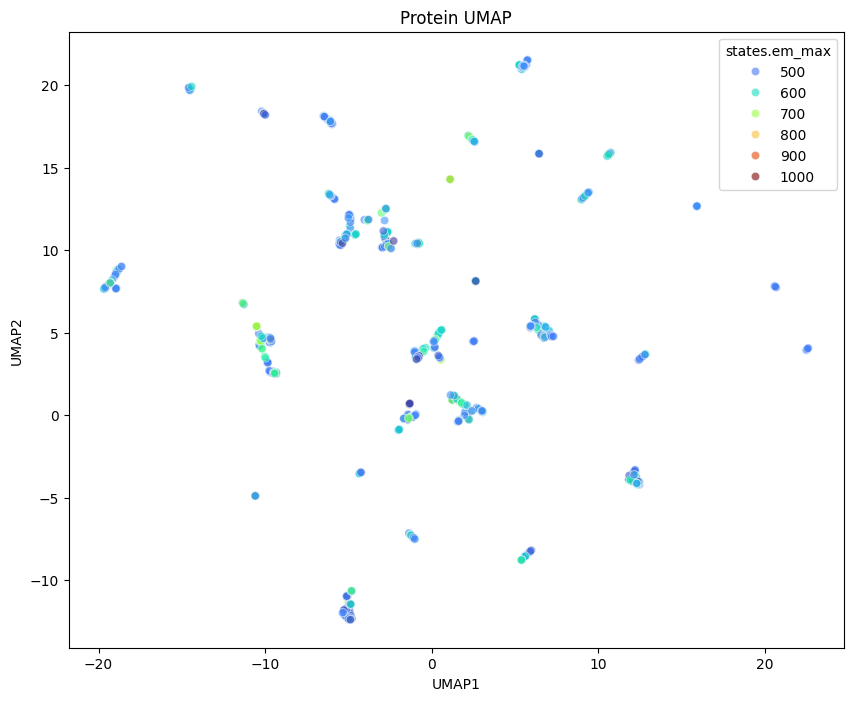

In [75]:


# Fit UMAP to the binary data
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
umap_embedding = reducer.fit_transform(protein_embeddings.drop(columns=['P_index','FP Name', discover_property]))

# Create a DataFrame for the UMAP results
umap_df = pd.DataFrame(umap_embedding, columns=["UMAP1", "UMAP2"])
umap_df['FP Name'] = protein_embeddings['FP Name']
umap_df[discover_property] = protein_embeddings[discover_property]

# Plot UMAP embedding with seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue=discover_property, palette="turbo", legend=True, alpha=0.6)
plt.title("Protein UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


/tmp/ipython-input-3936267714.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Spectral_r')  # reversed so 380→violet, 700→red


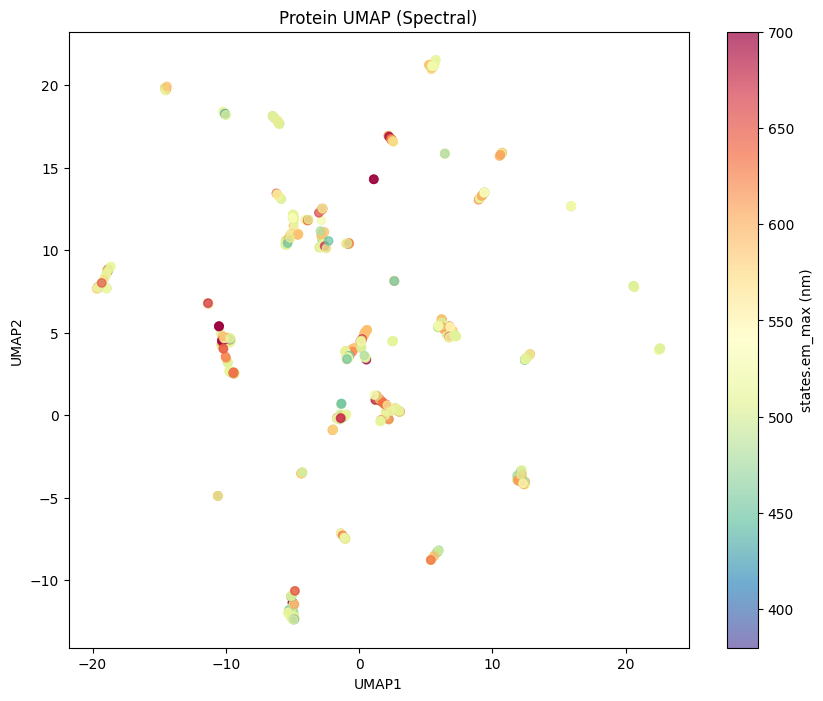

In [76]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Normalize discover_property values to [0, 1] for the colormap
norm = mcolors.Normalize(vmin=380, vmax=700)

# Use a perceptually uniform spectral colormap
cmap = cm.get_cmap('Spectral_r')  # reversed so 380→violet, 700→red

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    umap_df["UMAP1"],
    umap_df["UMAP2"],
    c=umap_df[discover_property],
    cmap=cmap,
    norm=norm,
    alpha=0.7
)

plt.colorbar(sc, label=f"{discover_property} (nm)")
plt.title("Protein UMAP (Spectral)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

# MSAs

In [77]:
!pip install Biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.6 MB/s eta 0:00:00


In [109]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Example: Creating a FASTA file from a list of sequences
sequences = []
for i, row in df.iterrows():
    record = SeqRecord(Seq(row['seq']), id=str(i))
    sequences.append(record)

SeqIO.write(sequences, "unaligned.fasta", "fasta")

805

In [89]:
!sudo apt-get update
!sudo apt-get install clustal-omega

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,817 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,479 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http://arch

In [88]:
import subprocess

# Example: Running Clustal Omega (ensure it's installed and in your PATH)
try:
    subprocess.run(["clustalo", "-i", "unaligned.fasta", "-o", "aligned.fasta", "--outfmt=fasta"], check=True)
    print("Alignment successful!")
except subprocess.CalledProcessError as e:
    print(f"Error during alignment: {e}")

FileNotFoundError: [Errno 2] No such file or directory: 'clustalo'

In [78]:
df

,seq,states.em_max,P_index
10B,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,525.0,P401
11,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,512.0,P379
(3-F)Tyr-EGFP,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,514.0,P802
5B,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,524.0,P398
A44-KR,MEGGPALFQSDMTFKIFIDGEVNGQKFTIVADGSSKFPHGDFNAHA...,520.0,P135
...,...,...,...
zFP538,MAHSKHGLKEEMTMKYHMEGCVNGHKFVITGEGIGYPFKGKQTINL...,538.0,P33
zoan2RFP,MAHSKHGLTDDMTMHFRMEGCVDGHKFVIEGNGNGNPFKGKQFINL...,576.0,P35
ZsGreen,MAQSKHGLTKEMTMKYRMEGCVDGHKFVITGEGIGYPFKGKQAINL...,506.0,P63
ZsGreen1,MAQSKHGLTKEMTMKYRMEGCVDGHKFVITGEGIGYPFKGKQAINL...,505.0,P62
